<h1>10次元の変数にて因果推論（効果量が一様でない）</h1>
10次元、交互作用項ありで因果推論

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import optim
import pyro
import pyro.distributions as dist
import seaborn as sns

from tensorboardX import SummaryWriter

from tqdm import tqdm
import time


import numpy as np
import random
from numpy.random import *
import matplotlib.pyplot as plt 
#np.random.seed(100)
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import csv

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

seed = 1234
rng = np.random.RandomState(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

In [11]:
size = 70000
treat = np.random.binomial(1,0.5,size=size)
beta2 = 0.8
beta3 = 0.3
beta4 = 0.5

beta5 = 0.4
beta6 = 0.3
beta7 = 0.5
beta8 = 0.3
beta9 = 0.2
beta10 = 0.2

eps = 1e-10
#b = np.random.normal(3,0.2)
b = 0
def mkdata(x1=treat,beta2=beta2,beta3=beta3, beta4=beta4,beta5=beta5,beta6=beta6,beta7=beta7,beta8=beta8,\
          beta9=beta9,beta10=beta10, b=b,size=size):
    #x1 = np.random.binomial(1,0.5,size=size)
    x2 = np.random.normal(1.4*x1+0.4,2.0,size=size)
    x3 = np.random.normal(-0.8*x1+1.3*x2,0.5,size=size)
    x4 = np.random.normal(0.2*x1-0.9*x2+2.3*x3,0.4,size=size)
    
    x5 = np.random.normal(0.4*x1+0.4,2.0,size=size)
    x6 = np.random.normal(-0.3*x1+1.5*x5+0.2,2.5,size=size)
    x7 = np.random.normal(0.2*x1+1.5*x5-1.4*x6,1.4,size=size)
    x8 = np.random.normal(1.0*x1+2.3*x7+1.2*x5,2.0,size=size)
    x9 = np.random.normal(-0.8*x1+0.4*x6+0.6*x2,1.5,size=size)
    x10 = np.random.normal(0.2*x1+0.5,1.4,size=size)
    
    effect = (0.4*x2+1.2*x3+0.8*x4+0.2*x5+0.1*x6+0.3*x7+0.2*x8+0.6*x9+0.2*x10-3)/10+1.5
    
    
    yogo= effect*x1+beta2*x2+beta3*x3+beta4*x4+beta5*x5+beta6*x6+beta7*x7+beta8*x8+beta9*x9+beta10*x10+b
    return(np.array((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,yogo)).T),effect

data,effect = mkdata(x1=treat,size=size)
train_data = np.array(data[:60000])#train[:,0]:conditional, train[:,1]:feature, train[:,2]:outcome
test_data  = np.array(data[60000:])
train_effect = np.array(effect[:60000])#train[:,0]:conditional, train[:,1]:feature, train[:,2]:outcome
test_effect  = np.array(effect[60000:])

In [12]:
import pandas as pd
trainpd=pd.DataFrame(train_data)
traineffectpd=pd.DataFrame(train_effect)

In [13]:
trainpd.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,2.589279,2.580153,3.288178,-1.044987,-1.904333,1.981953,4.028489,1.877027,-1.644037,5.746384
1,1.0,4.775125,5.468279,8.326355,-1.381808,0.466372,-3.038662,-4.793148,1.648792,1.939079,9.612269
2,1.0,5.119926,6.281422,9.908228,2.471244,3.194748,-0.638550,5.379441,4.313762,2.047526,18.869025
3,0.0,0.601103,0.959488,1.556958,1.859685,2.542314,-0.517165,6.723458,0.471785,0.145176,4.935623
4,1.0,-2.122185,-3.126468,-5.062517,0.479416,4.856955,-5.057609,-10.635202,-0.174301,2.183351,-8.773780


In [14]:
traineffectpd.head()

,0
0,2.056070
1,2.641021
2,3.420807
3,1.676521
4,0.061870


In [15]:
print(traineffectpd.mean())
print(traineffectpd.var())

0    1.563567
dtype: float64
0    0.758185
dtype: float64


5.091848557741072

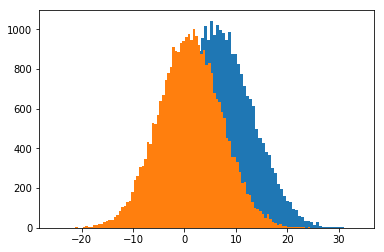

In [16]:
plt.hist(trainpd[(trainpd[0]==1)][10],bins=100)
plt.hist(trainpd[(trainpd[0]==0)][10],bins=100)
np.array(trainpd[(trainpd[0]==1)][10]).mean()-np.array(trainpd[(trainpd[0]==0)][10]).mean()

In [17]:
batch_size = 100
num_iters = 24000
num_epochs = int(batch_size* num_iters/len(train_data))

In [18]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [19]:
from pixyz.distributions import Bernoulli, Normal
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE

In [20]:
class Inference(Normal):
    def __init__(self, input_dim,cond_dim, hidden_dim, latent_dim):
        super(Inference, self).__init__(cond_var=["x"], var=["z"], name="q")
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, latent_dim)
        self.fc32 = nn.Linear(hidden_dim, latent_dim)
    def forward(self,x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

class Generator(Normal):
    def __init__(self, latent_dim,cond_dim, hidden_dim, output_dim):
        super(Generator, self).__init__(cond_var=["z"], var=["x"], name="p")
        
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, output_dim)
        self.fc32 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}


In [21]:
input_dim = len(data[0])-2
hidden_dim = 100
latent_dim = 2
output_dim = input_dim
cond_dim = 2
estimate_dim =1

In [22]:
input_dim

9

In [23]:
p = Generator(latent_dim,cond_dim, hidden_dim, output_dim)
q = Inference(input_dim,cond_dim, hidden_dim, latent_dim)


p.to(device)
q.to(device)


Inference(
  (fc1): Linear(in_features=9, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc31): Linear(in_features=100, out_features=2, bias=True)
  (fc32): Linear(in_features=100, out_features=2, bias=True)
)

In [24]:
loc = torch.tensor(0.)
scale = torch.tensor(1.)
prior = Normal(loc=loc, scale=scale, var=["z"], dim= latent_dim, name="p_prior")

In [25]:
kl = KullbackLeibler(q,prior)

In [26]:
model = VAE(q,p, regularizer = kl, optimizer=optim.Adam, optimizer_params={"lr":1e-4})

In [27]:
def input_shaper(x,input_dim):
    return x.view(-1, input_dim).float()
    
def tag_shaper(tag):
    return torch.eye(2)[tag.long()].float()



def train(epoch, input_dim):
    train_loss = 0
    for _data in tqdm(train_loader):
        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        
        x = x.to(device)
        loss = model.train({"x":x})
        train_loss += loss
    
    #pytorchのlossはデフォルトでは平均の値になる。このためバッチ長をかけて
    #全体で割って全体のlossを計算する
    
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch:{} Train loss:{:.4f}'.format(epoch, train_loss))
    return train_loss

In [183]:
data[0, 1:input_dim+1]

array([ 2.58927892,  2.58015295,  3.28817797, -1.0449871 , -1.9043332 ,
        1.98195295,  4.02848941,  1.87702723, -1.64403732])

In [182]:
def test(epoch, input_dim):
    test_loss = 0
    for _data in test_loader:

        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        x = x.to(device)
        
        loss = model.test({"x":x})
        test_loss += loss
    test_loss = test_loss * test_loader.batch_size/ len(test_loader.dataset)
    print('Test loss:{:.4f}'.format(test_loss))
    return test_loss

IndexError: too many indices for array

In [30]:
def plot_reconstrunction(x,y,output_dim):
    with torch.no_grad():
        z = q.sample({"x":x}, return_all=False)
        #z.update({"y":y})
        recon_batch = p.sample_mean(z).view(-1, output_dim)
        recon = torch.cat([x.view(-1, output_dim), recon_batch]).cpu()
        return recon

def plot_image_from_latent(z,y, output_dim):
    with torch.no_grad():
        sample = p.sample_mean({"z":z, "y":y}).view(-1, output_dim).cpu()
        return sample

def plot_reconstraction_changing_y(x,y, output_dim):
    y_change = torch.eye(2)[range(2)].to(device)
    batch_dummy = torch.ones(x.size(0))[:, None].to(device)
    recon_all = []
    
    with torch.no_grad():
        for _y in y_change:
            z = q.sample({"x": x, "y": y}, return_all=False)   #batch数だけx,yを代入
            z.update({"y": batch_dummy * _y[None,:]})
            
            recon_batch = p.sample_mean(z).view(-1, output_dim)
            recon_all.append(recon_batch)
            
        recon_changing_y = torch.cat(recon_all)
        recon_changing_y = torch.cat([x.view( -1, output_dim), recon_changing_y]).cpu()
        
        return recon_changing_y

In [31]:
writer = SummaryWriter()

plot_number = 1

z_sample = 0.5 * torch.randn(64, latent_dim).to(device)
y_sample = torch.eye(2)[[plot_number]*64].to(device)

_data = iter(test_loader).next()

_y = tag_shaper(_data[:,0])
_x = input_shaper(_data[:, 1:input_dim+1],input_dim)
_x = _x.to(device)
_y = _y.to(device)


for epoch in range(1, num_epochs + 1):
    train_loss = train(epoch, input_dim)
    test_loss = test(epoch, input_dim)
    
    recon = plot_reconstrunction(_x[:8], _y[:8], output_dim)
    #sample = plot_image_from_latent(z_sample, y_sample, output_dim)
    #recon_changing_y = plot_reconstraction_changing_y(_x[:8], _y[:8], output_dim)
    

    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)      
    """
    writer.add_image('Image_from_latent', sample, epoch)
    writer.add_image('Image_reconstrunction', recon, epoch)
    writer.add_image('Image_reconstrunction_change_y', recon_changing_y, epoch)
    """
writer.close()

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:1 Train loss:42.9003
Test loss:23.6704


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:2 Train loss:23.1516
Test loss:22.8057


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:3 Train loss:22.6697
Test loss:22.5945


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:4 Train loss:22.5416
Test loss:22.5289


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:5 Train loss:22.4491
Test loss:22.3175


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:6 Train loss:20.6623
Test loss:19.7193


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:7 Train loss:19.5496
Test loss:19.4889


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:8 Train loss:19.3909
Test loss:19.3171


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:9 Train loss:19.3251
Test loss:19.3423


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:10 Train loss:19.2878
Test loss:19.2788


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:11 Train loss:19.2675
Test loss:19.2597


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:12 Train loss:19.2543
Test loss:19.2235


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:13 Train loss:19.2332
Test loss:19.2721


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:14 Train loss:19.2189
Test loss:19.1899


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:15 Train loss:19.2196
Test loss:19.1801


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:16 Train loss:19.2043
Test loss:19.1785


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:17 Train loss:19.1950
Test loss:19.2368


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:18 Train loss:19.1952
Test loss:19.1980


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:19 Train loss:19.1730
Test loss:19.1654


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:20 Train loss:19.1736
Test loss:19.1783


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:21 Train loss:19.1680
Test loss:19.1374


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:22 Train loss:19.1557
Test loss:19.1653


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:23 Train loss:19.1448
Test loss:19.1154


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:24 Train loss:19.1519
Test loss:19.1932


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:25 Train loss:19.1261
Test loss:19.1058


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:26 Train loss:19.1072
Test loss:19.1001


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:27 Train loss:19.0741
Test loss:19.0124


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:28 Train loss:18.5326
Test loss:18.1815


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:29 Train loss:18.0520
Test loss:18.0169


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:30 Train loss:17.9766
Test loss:17.9551


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:31 Train loss:17.9548
Test loss:17.9329


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:32 Train loss:17.9382
Test loss:17.9351


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:33 Train loss:17.9260
Test loss:17.9198


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:34 Train loss:17.9290
Test loss:17.9245


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:35 Train loss:17.9276
Test loss:17.9482


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:36 Train loss:17.9083
Test loss:17.9069


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:37 Train loss:17.9023
Test loss:17.9039


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:38 Train loss:17.8979
Test loss:17.8871


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch:39 Train loss:17.8963
Test loss:17.8668


100%|██████████| 600/600 [00:03<00:00, 156.30it/s]


Epoch:40 Train loss:17.8959
Test loss:17.9245


In [32]:
input_dim+1

10

In [184]:
data[0, 1:input_dim+1]

array([ 2.58927892,  2.58015295,  3.28817797, -1.0449871 , -1.9043332 ,
        1.98195295,  4.02848941,  1.87702723, -1.64403732])

In [34]:
temp_data=np.array(data[:, 1:input_dim+1])
z=q.sample({"x":input_shaper(_data[:, 1:input_dim+1],input_dim).to(device)}, return_all=False)
x_hat=p.sample({"z":z.get("z")}, return_all=False)
x_out=x_hat.get("x").cpu()
x_in = _data[:, 1:input_dim+1]

(array([ 5.,  2., 16., 15., 25., 22.,  8.,  3.,  3.,  1.]),
 array([-4.0653152 , -2.8934784 , -1.7216415 , -0.5498047 ,  0.62203217,
         1.793869  ,  2.9657059 ,  4.1375427 ,  5.3093796 ,  6.4812164 ,
         7.6530533 ], dtype=float32),
 <a list of 10 Patch objects>)

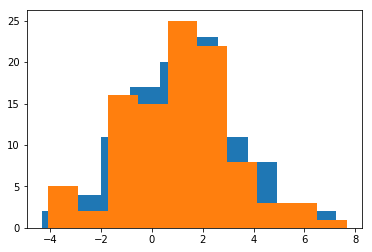

In [35]:
plt.hist(x_in[:,0],bins=10)
plt.hist(x_out[:,0],bins=10)

(array([ 5.,  3., 12., 14., 16., 28.,  9.,  7.,  3.,  3.]),
 array([-5.6989217e+00, -4.2751026e+00, -2.8512831e+00, -1.4274638e+00,
        -3.6444664e-03,  1.4201748e+00,  2.8439941e+00,  4.2678137e+00,
         5.6916327e+00,  7.1154518e+00,  8.5392714e+00], dtype=float32),
 <a list of 10 Patch objects>)

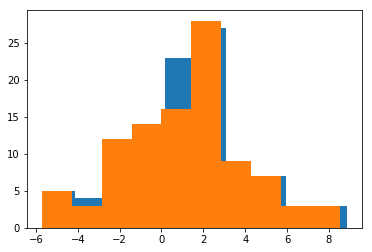

In [36]:
plt.hist(x_in[:,1])
plt.hist(x_out[:,1])

(array([ 4.,  4., 10., 18., 23., 25.,  6.,  5.,  3.,  2.]),
 array([-9.706548 , -7.2462306, -4.7859135, -2.3255963,  0.1347208,
         2.595038 ,  5.055355 ,  7.515672 ,  9.975989 , 12.436306 ,
        14.896624 ], dtype=float32),
 <a list of 10 Patch objects>)

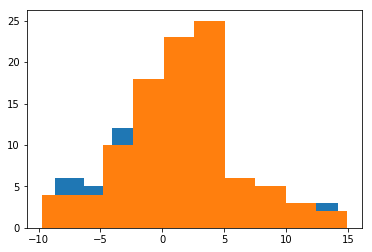

In [37]:
plt.hist(x_in[:,2])
plt.hist(x_out[:,2])

(array([ 2.,  6.,  5., 11., 15., 24., 21.,  7.,  5.,  4.]),
 array([-5.2066407 , -4.1084166 , -3.010192  , -1.9119676 , -0.8137433 ,
         0.28448105,  1.3827055 ,  2.4809299 ,  3.579154  ,  4.6773787 ,
         5.775603  ], dtype=float32),
 <a list of 10 Patch objects>)

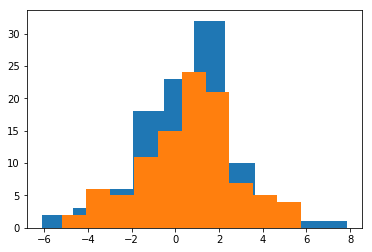

In [38]:
plt.hist(x_in[:,7])
plt.hist(x_out[:,7])

In [39]:
(x_in.float()-x_out.float()).mean(dim=0)

tensor([ 0.1562,  0.0607,  0.0197,  0.2566,  0.0960,  0.1744,  0.3681, -0.1026,
         0.3050])

In [40]:
class Estimator(nn.Module):
    def __init__(self, cond_dim, hidden_dim, latent_dim, estimate_dim):
        super(Estimator, self).__init__()
        
        self.fc1 = nn.Linear(latent_dim+cond_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, estimate_dim)
        
    def forward(self,z,y):
        h = F.relu(self.fc1(torch.cat([z,y],1)))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

criterion = nn.MSELoss()
model2 = Estimator(cond_dim, hidden_dim, latent_dim, estimate_dim)
model2.to(device)
optimizer = torch.optim.SGD(model2.parameters(),lr=1e-3)

In [41]:
for epoch in range(1, 15):
    for _data in tqdm(train_loader):
        y = tag_shaper(_data[:,0])
        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(_data[:, input_dim+1],estimate_dim)
        x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
        optimizer.zero_grad()
        
        z = q.sample({"x":x}, return_all=False)
        latent = z.get('z')
        output = model2(latent,y)
        loss = criterion(output,o)        
        loss.backward()
        
        optimizer.step()
    
    total = 0
    total_loss = 0
    for _data in test_loader:
        y = tag_shaper(_data[:,0])
        x = input_shaper(_data[:, 1:input_dim+1],input_dim)
        o = input_shaper(_data[:, input_dim+1],estimate_dim)
        x = x.to(device)
        y = y.to(device)
        o = o.to(device)
        
        z = q.sample({"x":x}, return_all=False)
        latent = z.get('z')
        output = model2(latent,y)
        loss = criterion(output,o)
        
        total_loss += loss *len(_data)
        total += len(_data)
    test_loss = total_loss/total
    
    print('Epochs:{}, train_Loss:{}, test_Loss:{:.2f}'.format(epoch,loss.item(), test_loss.item()))

  9%|▉         | 55/600 [00:00<00:00, 549.34it/s]

Epochs:1, train_Loss:18.88591766357422, test_Loss:15.28


 10%|▉         | 59/600 [00:00<00:00, 584.39it/s]

Epochs:2, train_Loss:19.428050994873047, test_Loss:15.13


 10%|▉         | 59/600 [00:00<00:00, 589.07it/s]

Epochs:3, train_Loss:19.009628295898438, test_Loss:15.04


 10%|▉         | 59/600 [00:00<00:00, 588.36it/s]

Epochs:4, train_Loss:19.433372497558594, test_Loss:15.10


  8%|▊         | 46/600 [00:00<00:01, 452.54it/s]

Epochs:5, train_Loss:18.922468185424805, test_Loss:15.02


  8%|▊         | 51/600 [00:00<00:01, 502.34it/s]

Epochs:6, train_Loss:19.16899871826172, test_Loss:14.98


 10%|▉         | 59/600 [00:00<00:00, 582.95it/s]

Epochs:7, train_Loss:19.364587783813477, test_Loss:14.99


  8%|▊         | 47/600 [00:00<00:01, 465.96it/s]

Epochs:8, train_Loss:19.107301712036133, test_Loss:14.98


 10%|▉         | 59/600 [00:00<00:00, 585.28it/s]

Epochs:9, train_Loss:18.893722534179688, test_Loss:14.94


 10%|▉         | 58/600 [00:00<00:00, 571.70it/s]

Epochs:10, train_Loss:19.34331703186035, test_Loss:14.93


  8%|▊         | 48/600 [00:00<00:01, 472.83it/s]

Epochs:11, train_Loss:19.434585571289062, test_Loss:14.98


  8%|▊         | 47/600 [00:00<00:01, 464.44it/s]

Epochs:12, train_Loss:18.75942039489746, test_Loss:14.93


  8%|▊         | 49/600 [00:00<00:01, 481.94it/s]

Epochs:13, train_Loss:18.752103805541992, test_Loss:14.98


100%|██████████| 600/600 [00:01<00:00, 484.67it/s]


Epochs:14, train_Loss:19.36590003967285, test_Loss:14.98


In [42]:
pt_size = 10000
z_sample = 0.3* torch.randn(pt_size, latent_dim).to(device)

# 非治療群を生成
plot_number = 0
uy_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
untreated=model2(z_sample,uy_sample)

# 治療群を生成
plot_number = 1
ty_sample = torch.eye(2)[[plot_number]*pt_size].to(device)
treated=model2(z_sample,ty_sample)

In [43]:
detach_z=pd.DataFrame(z_sample.cpu().detach().numpy())
detach_u=pd.DataFrame(untreated.cpu().detach().numpy())
detach_t=pd.DataFrame(treated.cpu().detach().numpy())

In [65]:
generated=pd.concat([detach_z,detach_u,detach_t,detach_t-detach_u],axis=1)

In [71]:
generated.columns=['z0','z1','untreated','treated','treated_untreated']

In [72]:
generated.head()

,z0,z1,untreated,treated,treated_untreated
0,-0.181405,0.058085,1.354282,4.232104,2.877821
1,-0.056114,-0.209938,1.559793,4.486381,2.926589
2,0.012855,0.068254,2.288713,5.260086,2.971374
3,0.231470,0.499774,3.761351,7.070105,3.308754
4,-0.205121,0.075532,1.261690,4.131668,2.869977


In [73]:
sub_gen=generated[:3000]

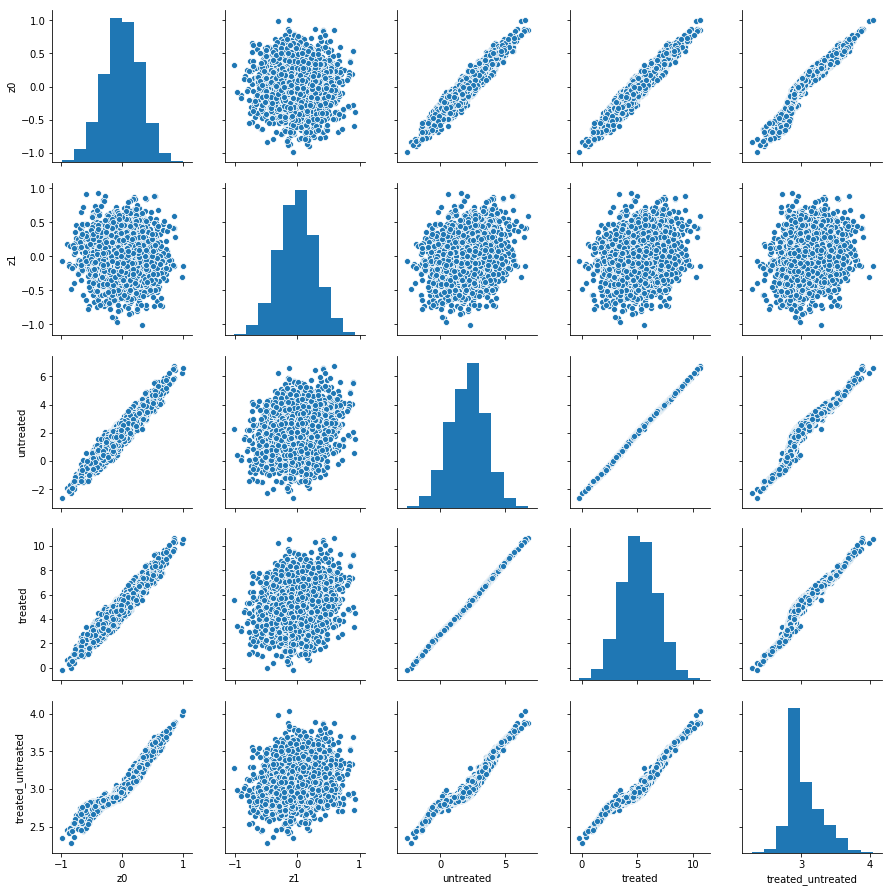

In [74]:
sns.pairplot(sub_gen)

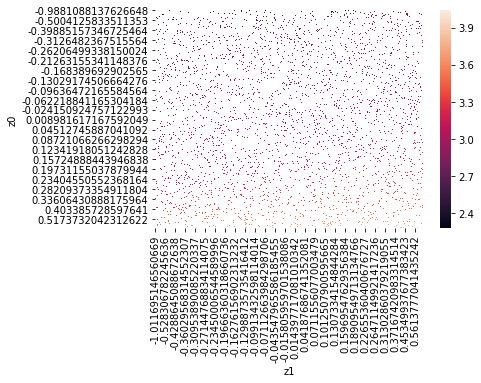

In [139]:
sns.heatmap(sub_gen.pivot_table("treated_untreated",index="z0",columns="z1"))

In [120]:
sub_gen.values[:,-1]

array([2.8778214, 2.9265885, 2.9713736, ..., 2.8982658, 2.958663 ,
       3.2883322], dtype=float32)

/root/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


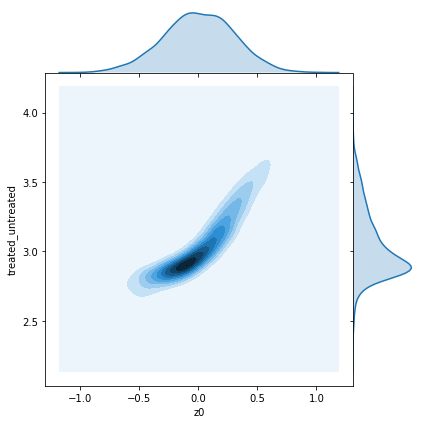

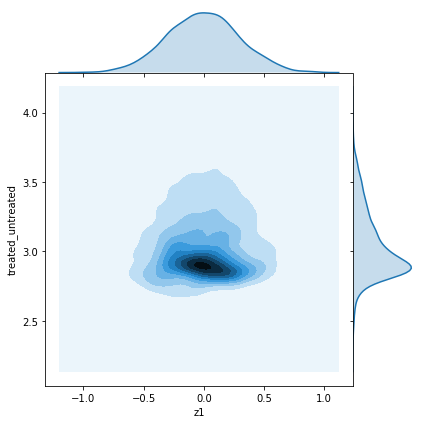

In [87]:
sns.jointplot(x=sub_gen["z0"], y=sub_gen["treated_untreated"], data=sub_gen, space=0, kind='kde')
sns.jointplot(x=sub_gen["z1"], y=sub_gen["treated_untreated"], data=sub_gen, space=0, kind='kde')

In [143]:
temp_data=np.array(data[:3000, 1:input_dim+1])
z=q.sample({"x":input_shaper(_data[:, 1:input_dim+1],input_dim).to(device)}, return_all=False)
x_hat=p.sample({"z":z.get("z")}, return_all=False)
x_out=x_hat.get("x").cpu()
x_in = _data[:, 1:input_dim+1]

In [161]:
data_graph=pd.concat((pd.DataFrame(train_data[:3000]),pd.DataFrame(train_effect[:3000])),axis=1)
data_graph.columns=['treatment','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','effect']

In [164]:
data_graph.head()

,treatment,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,effect
0,0.0,2.589279,2.580153,3.288178,-1.044987,-1.904333,1.981953,4.028489,1.877027,-1.644037,5.746384,2.056070
1,1.0,4.775125,5.468279,8.326355,-1.381808,0.466372,-3.038662,-4.793148,1.648792,1.939079,9.612269,2.641021
2,1.0,5.119926,6.281422,9.908228,2.471244,3.194748,-0.638550,5.379441,4.313762,2.047526,18.869025,3.420807
3,0.0,0.601103,0.959488,1.556958,1.859685,2.542314,-0.517165,6.723458,0.471785,0.145176,4.935623,1.676521
4,1.0,-2.122185,-3.126468,-5.062517,0.479416,4.856955,-5.057609,-10.635202,-0.174301,2.183351,-8.773780,0.061870


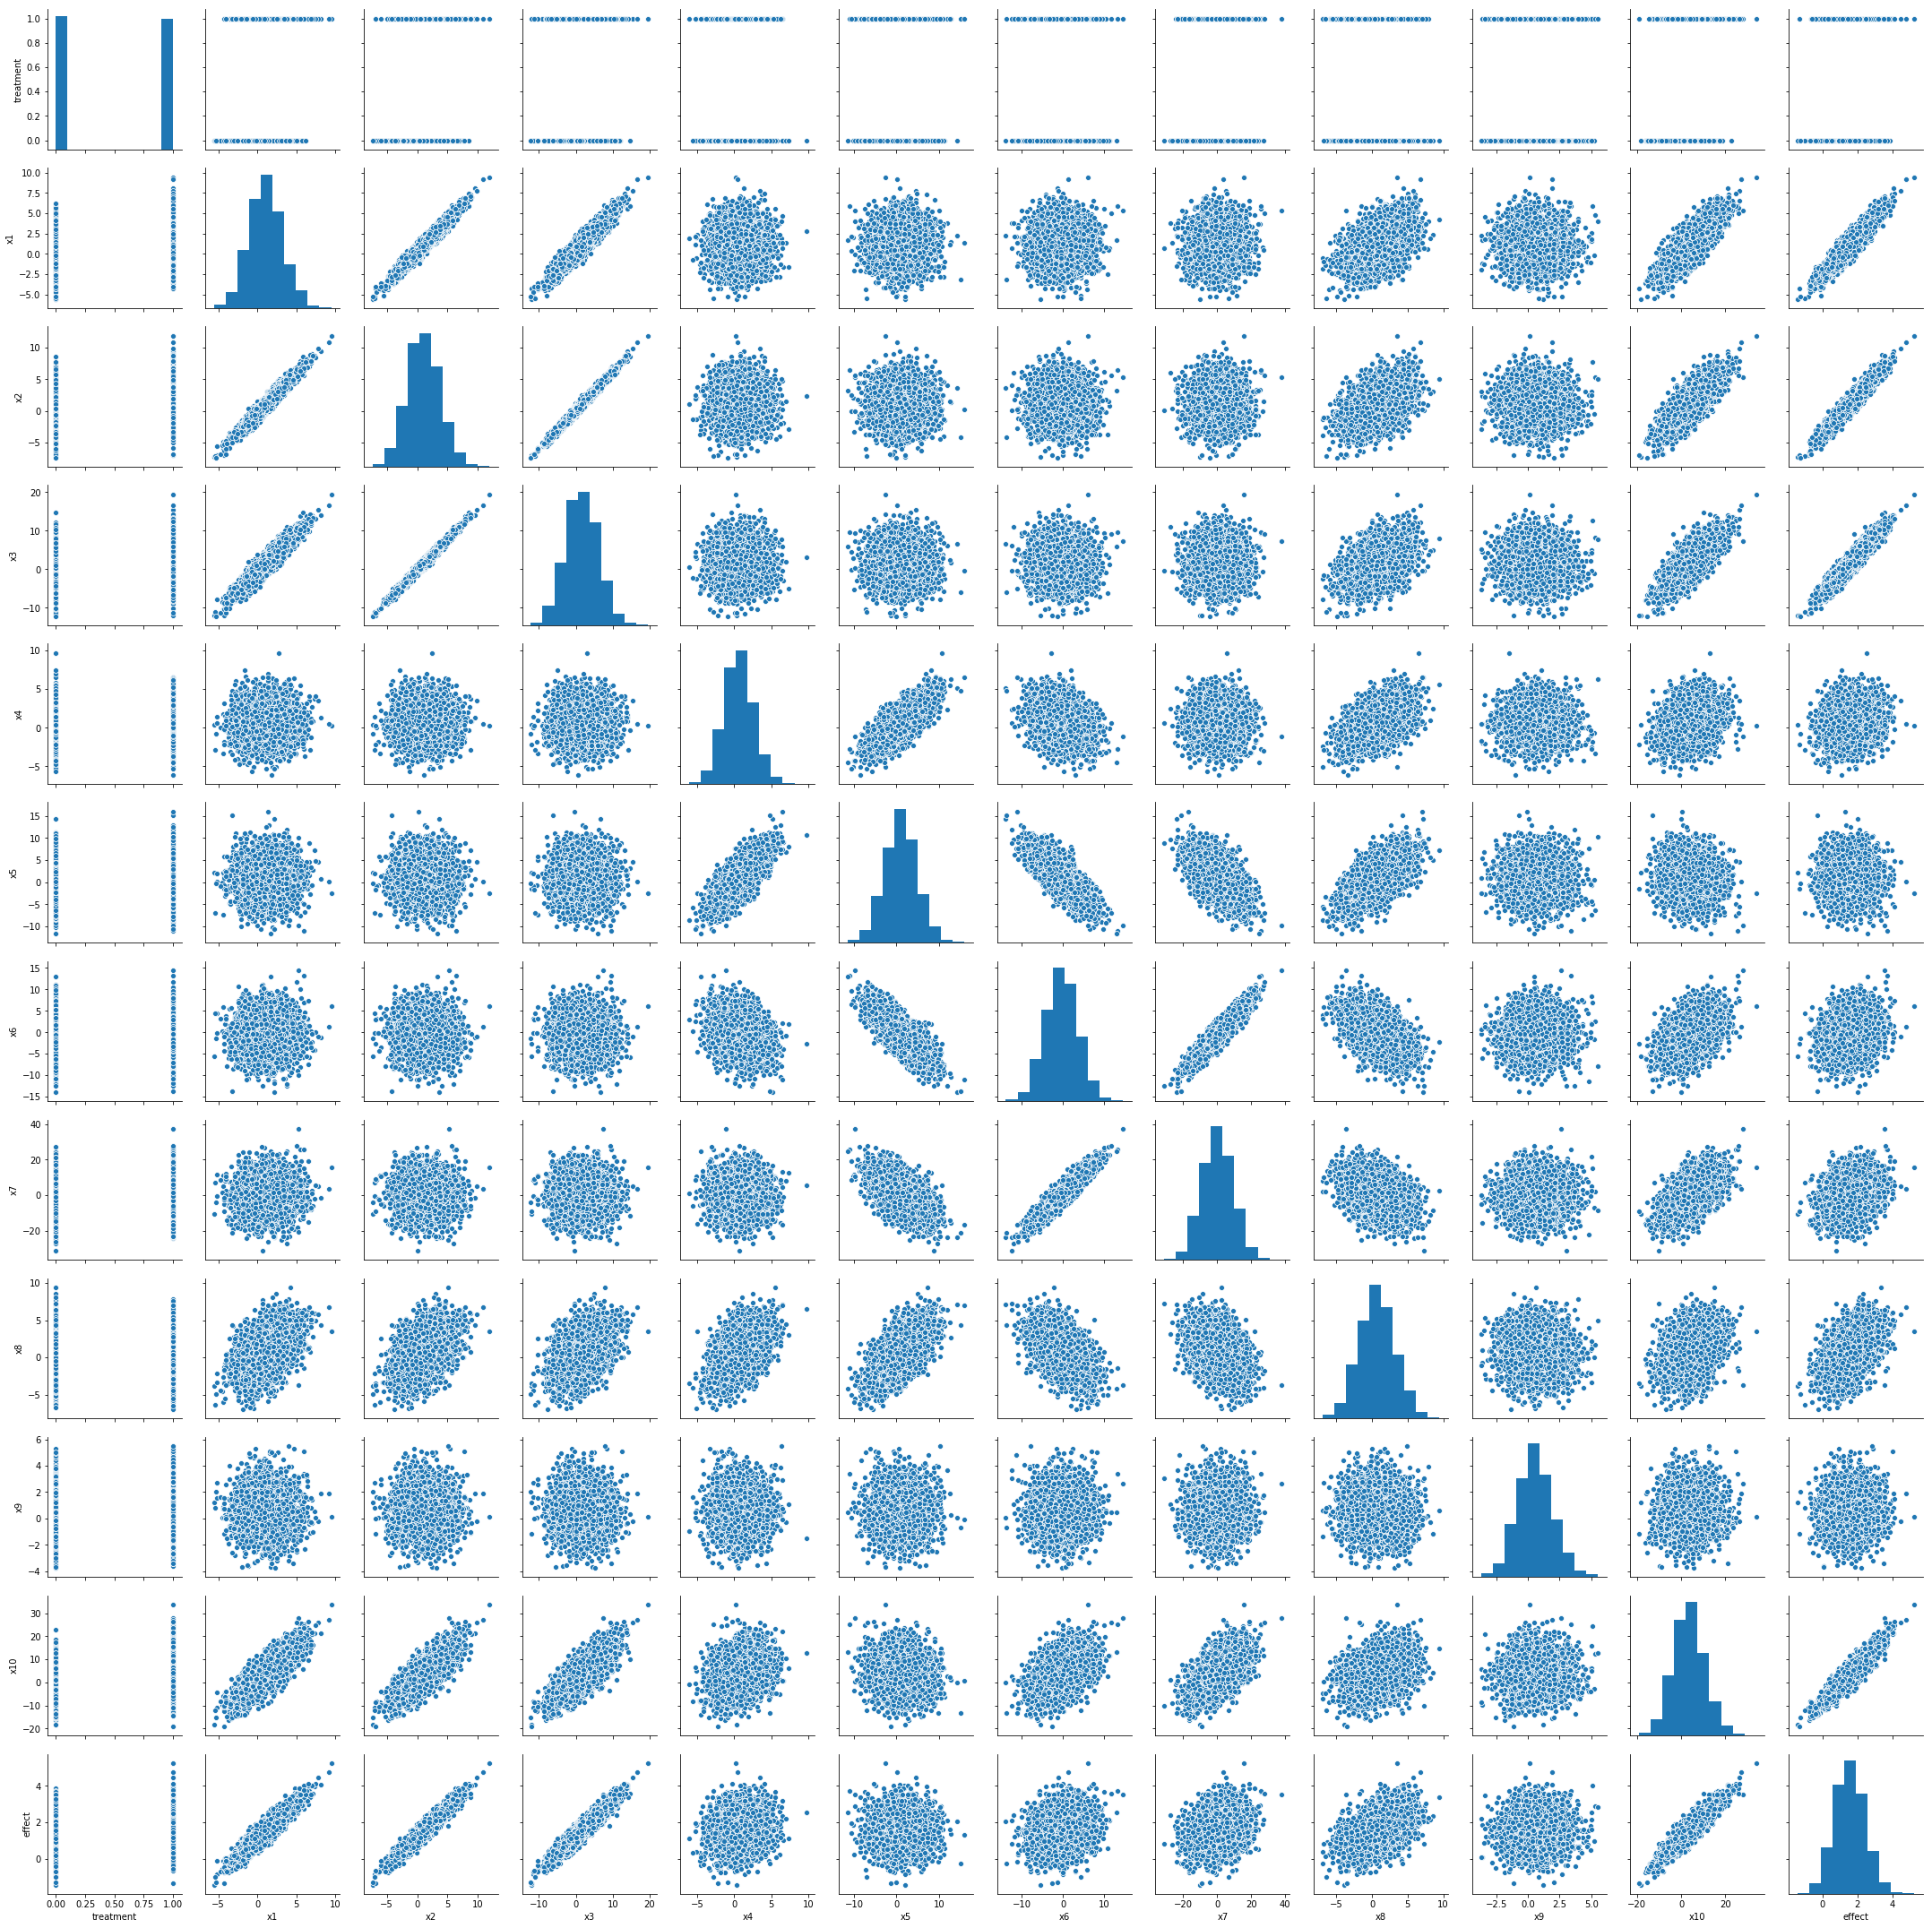

In [165]:
sns.pairplot(data_graph)

In [262]:
data_graph.head()

,treatment,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,effect
0,0.0,2.589279,2.580153,3.288178,-1.044987,-1.904333,1.981953,4.028489,1.877027,-1.644037,5.746384,2.056070
1,1.0,4.775125,5.468279,8.326355,-1.381808,0.466372,-3.038662,-4.793148,1.648792,1.939079,9.612269,2.641021
2,1.0,5.119926,6.281422,9.908228,2.471244,3.194748,-0.638550,5.379441,4.313762,2.047526,18.869025,3.420807
3,0.0,0.601103,0.959488,1.556958,1.859685,2.542314,-0.517165,6.723458,0.471785,0.145176,4.935623,1.676521
4,1.0,-2.122185,-3.126468,-5.062517,0.479416,4.856955,-5.057609,-10.635202,-0.174301,2.183351,-8.773780,0.061870


In [265]:
temp=torch.from_numpy(data_graph.values[:, 1:input_dim+1]).to(device)
z = q.sample({"x":input_shaper(temp,input_dim)}, return_all=False)
z_pd=pd.DataFrame(z.get("z").cpu().detach().numpy())

In [267]:
z_pd.shape

(3000, 2)

In [268]:
data_graph.shape

(3000, 12)

In [318]:
x_to_z=pd.concat((data_graph,z_pd),axis=1)

In [319]:
x_to_z.head()

,treatment,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,effect,0,1
0,0.0,2.589279,2.580153,3.288178,-1.044987,-1.904333,1.981953,4.028489,1.877027,-1.644037,5.746384,2.056070,0.493308,0.452765
1,1.0,4.775125,5.468279,8.326355,-1.381808,0.466372,-3.038662,-4.793148,1.648792,1.939079,9.612269,2.641021,1.609270,0.332840
2,1.0,5.119926,6.281422,9.908228,2.471244,3.194748,-0.638550,5.379441,4.313762,2.047526,18.869025,3.420807,1.938054,-0.608475
3,0.0,0.601103,0.959488,1.556958,1.859685,2.542314,-0.517165,6.723458,0.471785,0.145176,4.935623,1.676521,0.067290,-0.424209
4,1.0,-2.122185,-3.126468,-5.062517,0.479416,4.856955,-5.057609,-10.635202,-0.174301,2.183351,-8.773780,0.061870,-1.594096,-0.716819


In [375]:
X=x_to_z[['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']]
Z=x_to_z[[0,1]]
E=x_to_z[['effect']]

In [378]:
E.shape

(3000, 1)

In [346]:
from sklearn.manifold import TSNE

In [347]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X)

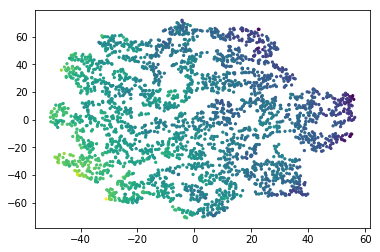

In [373]:
plt.scatter(X_reduced[:,0],X_reduced[:,1],s=5,c=Z[0])

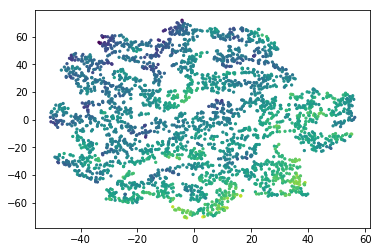

In [374]:
plt.scatter(X_reduced[:,0],X_reduced[:,1],s=5,c=Z[1])

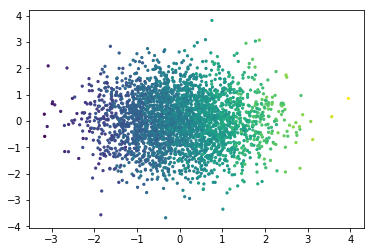

In [407]:
plt.scatter(Z[0],Z[1],s=5,c=np.array(E, dtype='float32').reshape(-1))

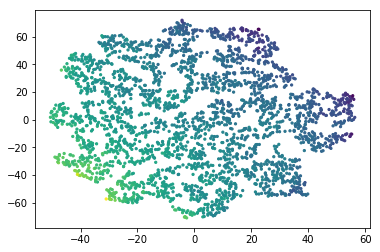

In [408]:
plt.scatter(X_reduced[:,0],X_reduced[:,1],s=5,c=np.array(E, dtype='float32').reshape(-1))